# Exercise 4

## Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [3]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        prediction = model(data)
        
        # TODO: compute negative log likelihood loss
        loss = F.nll_loss(prediction, target)
        
        # TODO: do backpropagation
        loss.backward()
        
        # TODO: optimize
        optimizer.step()        
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch} | Batch: {batch_idx} | Loss: {loss.item():.4f}")

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [4]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet3"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [ ]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()

        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.flatten = nn.Flatten()
        
        self.stack_layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 100),
            nn.Sigmoid(),
            nn.Linear(100, 60),
            nn.Sigmoid(),
            nn.Linear(60, 30),
            nn.Sigmoid(),
            nn.Linear(30, 10)
        )


    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run network layers
        output = self.stack_layers(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(output, dim=1)
        
        return output

In [ ]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()

        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.flatten = nn.Flatten()
                    
        self.stack_layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.ReLU(),
            nn.Linear(60, 30),
            nn.ReLU(),
            nn.Linear(30, 10)
        )

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run network layers
        output = self.stack_layers(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(output, dim=1)
        
        return output

In [ ]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()

        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.flatten = nn.Flatten()
                    
        self.stack_layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.BatchNorm1d(200), # batch normalization after 1st layer
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.BatchNorm1d(60), # batch normalization after 3rd layer
            nn.ReLU(),
            nn.Linear(60, 30),
            nn.ReLU(),
            nn.Linear(30, 10)
        )
        
    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run network layers
        output = self.stack_layers(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(output, dim=1)
        
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [ ]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        self.flatten = nn.Flatten()
        # TODO: initialize network layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3), # 1x28x28->32x26x26
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2), # 32x26x26->64x12x12
            nn.ReLU()
        )

        self.fully_connected_layers = nn.Sequential(
            nn.Linear(64*12*12, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv_layers(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run fully connected layers
        x = self.fully_connected_layers(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [20]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()

        self.flatten = nn.Flatten()
        # TODO: initialize network layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3), # 1x28x28->32x26x26
            nn.BatchNorm2d(32), # batch normalization after 1st convolutional layer
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2), # 32x26x26->64x12x12
            nn.ReLU()
        )

        self.fully_connected_layers = nn.Sequential(
            nn.Linear(64*12*12, 128),
            nn.BatchNorm1d(128), # batch normalization after 1st fully connected layer
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv_layers(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run fully connected layers
        x = self.fully_connected_layers(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [23]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()

        self.flatten = nn.Flatten()
        # TODO: initialize network layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3), # 1x28x28->32x26x26
            nn.BatchNorm2d(32), # batch normalization after 1st convolutional layer
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), # 32x26x26->64x24x24
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 64x24x24 -> 64x12x12
        )

        self.fully_connected_layers = nn.Sequential(
            nn.Linear(64*12*12, 128),
            nn.BatchNorm1d(128), # batch normalization after 1st fully connected layer
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv_layers(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run fully connected layers
        x = self.fully_connected_layers(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

Epoch: 1 | Batch: 0 | Loss: 2.4147
Epoch: 1 | Batch: 100 | Loss: 0.1039
Epoch: 1 | Batch: 200 | Loss: 0.1113
Epoch: 1 | Batch: 300 | Loss: 0.0225
Epoch: 1 | Batch: 400 | Loss: 0.0169
Epoch: 1 | Batch: 500 | Loss: 0.1252
Epoch: 1 | Batch: 600 | Loss: 0.1484
Epoch: 1 | Batch: 700 | Loss: 0.0065
Epoch: 1 | Batch: 800 | Loss: 0.0432
Epoch: 1 | Batch: 900 | Loss: 0.0210

Test set: Average loss: 0.0343, Accuracy: 9888/10000 (98.88%)



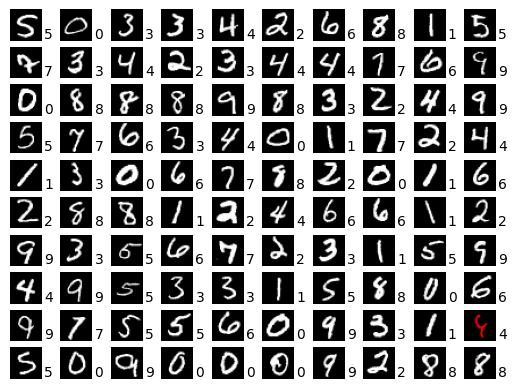

Epoch: 2 | Batch: 0 | Loss: 0.0796
Epoch: 2 | Batch: 100 | Loss: 0.0363
Epoch: 2 | Batch: 200 | Loss: 0.0118
Epoch: 2 | Batch: 300 | Loss: 0.0166
Epoch: 2 | Batch: 400 | Loss: 0.0183
Epoch: 2 | Batch: 500 | Loss: 0.0126
Epoch: 2 | Batch: 600 | Loss: 0.0255
Epoch: 2 | Batch: 700 | Loss: 0.0042
Epoch: 2 | Batch: 800 | Loss: 0.0277
Epoch: 2 | Batch: 900 | Loss: 0.0123

Test set: Average loss: 0.0265, Accuracy: 9917/10000 (99.17%)



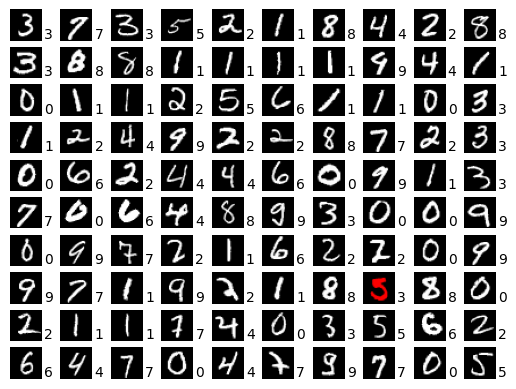

Epoch: 3 | Batch: 0 | Loss: 0.0109
Epoch: 3 | Batch: 100 | Loss: 0.0057
Epoch: 3 | Batch: 200 | Loss: 0.0012
Epoch: 3 | Batch: 300 | Loss: 0.0133
Epoch: 3 | Batch: 400 | Loss: 0.0020
Epoch: 3 | Batch: 500 | Loss: 0.0026
Epoch: 3 | Batch: 600 | Loss: 0.0030
Epoch: 3 | Batch: 700 | Loss: 0.0073
Epoch: 3 | Batch: 800 | Loss: 0.0043
Epoch: 3 | Batch: 900 | Loss: 0.0035

Test set: Average loss: 0.0234, Accuracy: 9917/10000 (99.17%)



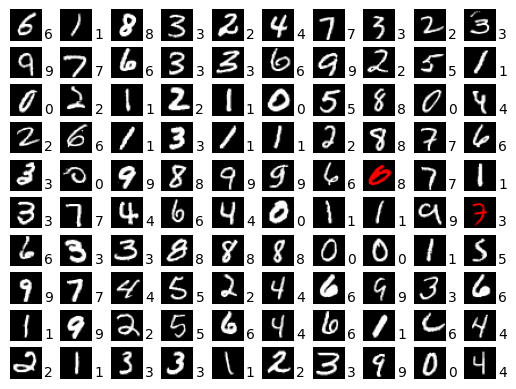

Epoch: 4 | Batch: 0 | Loss: 0.0004
Epoch: 4 | Batch: 100 | Loss: 0.0016
Epoch: 4 | Batch: 200 | Loss: 0.0070
Epoch: 4 | Batch: 300 | Loss: 0.0085
Epoch: 4 | Batch: 400 | Loss: 0.0165
Epoch: 4 | Batch: 500 | Loss: 0.0150
Epoch: 4 | Batch: 600 | Loss: 0.0008
Epoch: 4 | Batch: 700 | Loss: 0.0037
Epoch: 4 | Batch: 800 | Loss: 0.0009
Epoch: 4 | Batch: 900 | Loss: 0.0304

Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)



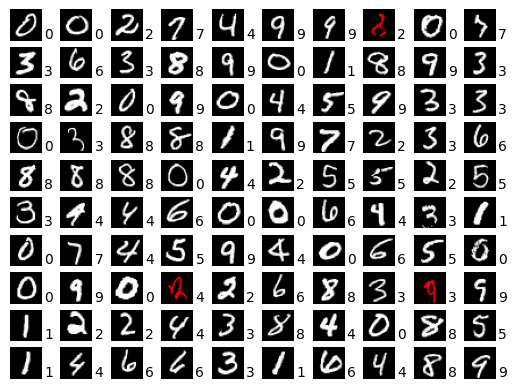

Epoch: 5 | Batch: 0 | Loss: 0.0097
Epoch: 5 | Batch: 100 | Loss: 0.0012
Epoch: 5 | Batch: 200 | Loss: 0.0039
Epoch: 5 | Batch: 300 | Loss: 0.0014
Epoch: 5 | Batch: 400 | Loss: 0.0033
Epoch: 5 | Batch: 500 | Loss: 0.0004
Epoch: 5 | Batch: 600 | Loss: 0.0009
Epoch: 5 | Batch: 700 | Loss: 0.0012
Epoch: 5 | Batch: 800 | Loss: 0.0127
Epoch: 5 | Batch: 900 | Loss: 0.0050

Test set: Average loss: 0.0233, Accuracy: 9930/10000 (99.30%)



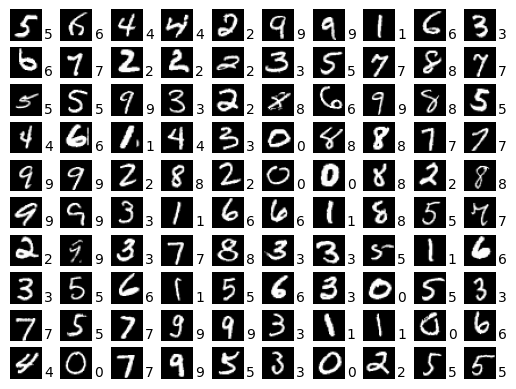

In [ ]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 5
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

''' CHANGE THE MODEL HERE '''
model = ConvNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")